In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Churn_Modelling.csv')
df = pd.DataFrame(data)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#Data Preprocessing

In [3]:
from sklearn import preprocessing
#Drop unused columns

df.drop(columns=["RowNumber","CustomerId","Surname"],
                  inplace=True)

df_clean = df.copy()


#One Hot Encoding

one_hot = pd.get_dummies(df_clean['Geography'], prefix='Geography')
df_clean = df_clean.drop('Geography', axis=1)
df_clean = df_clean.join(one_hot)

#Label Encoding
df_clean['Gender']=df_clean['Gender'].map({'Male':1,'Female':0})


In [4]:
df_clean

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0,1,0


#Feature Scaling

In [5]:
from sklearn.preprocessing import StandardScaler
cols = ["CreditScore","Age","Tenure","Balance","EstimatedSalary","NumOfProducts","HasCrCard","IsActiveMember","Gender","Geography_France","Geography_Germany","Geography_Spain"]
df_clean[cols] = StandardScaler().fit_transform(df_clean[cols])

# Train and Test Split

In [6]:
from sklearn.model_selection import train_test_split

y = df_clean["Exited"]
x = df_clean.drop(columns=["Exited"], inplace=False)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
print("train data")
print(pd.DataFrame(x_train).shape)
print(pd.DataFrame(y_train).shape)
print("")
print("test data")
print(pd.DataFrame(x_test).shape)
print(pd.DataFrame(y_test).shape)

train data
(6000, 12)
(6000, 1)

test data
(4000, 12)
(4000, 1)


#KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
pred_prob_knn = knn.predict_proba(x_test)

#Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred_rfc = rfc.predict(x_test)
pred_prob_rfc = rfc.predict_proba(x_test)

#Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train,y_train)
y_pred_logreg=logreg.predict(x_test)
pred_prob_logreg = logreg.predict_proba(x_test)

In [14]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, pred_prob_knn[:,1], pos_label=1)
fpr_rfc, tpr_rfc, thresh_rfc = roc_curve(y_test, pred_prob_rfc[:,1], pos_label=1)
fpr_logreg, tpr_logreg, thresh_logreg = roc_curve(y_test, pred_prob_logreg[:,1], pos_label=1)

In [15]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [16]:

from sklearn.metrics import roc_auc_score

# auc scores
auc_score_knn = roc_auc_score(y_test, pred_prob_knn[:,1])
auc_score_rfc = roc_auc_score(y_test, pred_prob_rfc[:,1])
auc_score_logreg = roc_auc_score(y_test, pred_prob_logreg[:,1])

In [17]:
print(auc_score_knn,auc_score_rfc,auc_score_logreg)

0.7558202716823407 0.845994814040791 0.7659715933279152


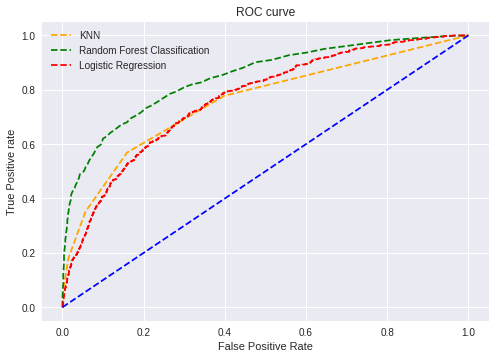

In [21]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_knn, tpr_knn, linestyle='--',color='orange', label='KNN')
plt.plot(fpr_rfc, tpr_rfc, linestyle='--',color='green', label='Random Forest Classification')
plt.plot(fpr_logreg, tpr_logreg, linestyle='--',color='red', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#Test Model Stability

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

#Random Forest Classification

In [27]:
rfc_cv_score = cross_val_score(rfc, x, y, cv=10, scoring='roc_auc')

In [28]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_rfc))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_rfc))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[3081  109]
 [ 442  368]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      3190
           1       0.77      0.45      0.57       810

    accuracy                           0.86      4000
   macro avg       0.82      0.71      0.74      4000
weighted avg       0.85      0.86      0.85      4000



=== All AUC Scores ===
[0.8626558  0.83050978 0.87406395 0.83642477 0.86230786 0.84265383
 0.85066571 0.87070047 0.85530097 0.84136633]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8526649479577604


#Tuning Hyperparameter



In [31]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(x_train, y_train)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 24.5min finished


{'n_estimators': 2000, 'max_features': 'sqrt', 'max_depth': 220}


In [48]:
rfc = RandomForestClassifier(n_estimators=2000, max_depth=220, max_features='sqrt')
rfc.fit(x_train,y_train)
rfc_predict = rfc.predict(x_test)
rfc_predict_proba = rfc.predict_proba(x_test)
rfc_cv_score = cross_val_score(rfc, x, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[3080  110]
 [ 439  371]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      3190
           1       0.77      0.46      0.57       810

    accuracy                           0.86      4000
   macro avg       0.82      0.71      0.75      4000
weighted avg       0.85      0.86      0.85      4000



=== All AUC Scores ===
[0.86434932 0.84049229 0.8783778  0.83961166 0.86825057 0.84506786
 0.85638979 0.8724311  0.86065047 0.84314022]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8568761081897487


#Logistic Regression

In [35]:
logreg_cv_score = cross_val_score(logreg, x, y, cv=10, scoring='roc_auc')

In [36]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_logreg))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_logreg))
print('\n')
print("=== All AUC Scores ===")
print(logreg_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Logistic Regression: ", logreg_cv_score.mean())

=== Confusion Matrix ===
[[3062  128]
 [ 641  169]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3190
           1       0.57      0.21      0.31       810

    accuracy                           0.81      4000
   macro avg       0.70      0.58      0.60      4000
weighted avg       0.77      0.81      0.77      4000



=== All AUC Scores ===
[0.79331708 0.76969406 0.77925165 0.74806015 0.7548958  0.79066287
 0.75975466 0.77654505 0.75104919 0.73704965]


=== Mean AUC Score ===
Mean AUC Score - Logistic Regression:  0.7660280162012332


#Tuning Hyperparameter

In [39]:
from sklearn.model_selection import RandomizedSearchCV
#List Hyperparameters yang akan diuji
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

# Random search of parameters
logreg_random = RandomizedSearchCV(estimator = logreg, param_distributions = grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
logreg_random.fit(x_train, y_train)
# print results
print(logreg_random.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.1}


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.2s finished


In [47]:
logreg = LogisticRegression(solver='liblinear',penalty='l1',C=0.1)
logreg.fit(x_train,y_train)
logreg_predict = logreg.predict(x_test)
logreg_predict_proba = logreg.predict_proba(x_test)
logreg_cv_score = cross_val_score(logreg, x, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_logreg))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_logreg))
print('\n')
print("=== All AUC Scores ===")
print(logreg_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Logistic Regression: ", logreg_cv_score.mean())

=== Confusion Matrix ===
[[3062  128]
 [ 641  169]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      3190
           1       0.57      0.21      0.31       810

    accuracy                           0.81      4000
   macro avg       0.70      0.58      0.60      4000
weighted avg       0.77      0.81      0.77      4000



=== All AUC Scores ===
[0.79352646 0.76982954 0.77972584 0.74825106 0.75591807 0.79084762
 0.76008104 0.77635962 0.75104919 0.73718563]


=== Mean AUC Score ===
Mean AUC Score - Logistic Regression:  0.766277406952921


#KNN

In [42]:
knn_cv_score = cross_val_score(knn, x, y, cv=10, scoring='roc_auc')

In [44]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_knn))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_knn))
print('\n')
print("=== All AUC Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - KNN: ", knn_cv_score.mean())

=== Confusion Matrix ===
[[3009  181]
 [ 525  285]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      3190
           1       0.61      0.35      0.45       810

    accuracy                           0.82      4000
   macro avg       0.73      0.65      0.67      4000
weighted avg       0.80      0.82      0.80      4000



=== All AUC Scores ===
[0.78929266 0.74830956 0.80487918 0.78057259 0.7902164  0.74685314
 0.7654264  0.77746599 0.75149112 0.76400727]


=== Mean AUC Score ===
Mean AUC Score - KNN:  0.7718514310999379


#Tuning Hyperparameter

In [45]:
from sklearn.model_selection import RandomizedSearchCV
#List Hyperparameters yang akan diuji
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

# define grid search
grid = dict(leaf_size=leaf_size,n_neighbors=n_neighbors,p=p)

# Random search of parameters
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
knn_random.fit(x_train, y_train)
# print results
print(knn_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   42.6s


{'p': 1, 'n_neighbors': 5, 'leaf_size': 47}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


In [52]:
knn = KNeighborsClassifier(p=1,n_neighbors=5,leaf_size=47)
knn.fit(x_train,y_train)
knn_predict = knn.predict(x_test)
knn_predict_proba = knn.predict_proba(x_test)
knn_cv_score = cross_val_score(knn, x, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_knn))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_knn))
print('\n')
print("=== All AUC Scores ===")
print(knn_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - KNN: ", knn_cv_score.mean())

=== Confusion Matrix ===
[[3009  181]
 [ 525  285]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      3190
           1       0.61      0.35      0.45       810

    accuracy                           0.82      4000
   macro avg       0.73      0.65      0.67      4000
weighted avg       0.80      0.82      0.80      4000



=== All AUC Scores ===
[0.7858071  0.74558762 0.79319391 0.79480737 0.77888831 0.74283489
 0.75703887 0.780748   0.77277784 0.77105958]


=== Mean AUC Score ===
Mean AUC Score - KNN:  0.7722743491693802


In [53]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, knn_predict_proba[:,1], pos_label=1)
fpr_rfc, tpr_rfc, thresh_rfc = roc_curve(y_test, rfc_predict_proba[:,1], pos_label=1)
fpr_logreg, tpr_logreg, thresh_logreg = roc_curve(y_test, logreg_predict_proba[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

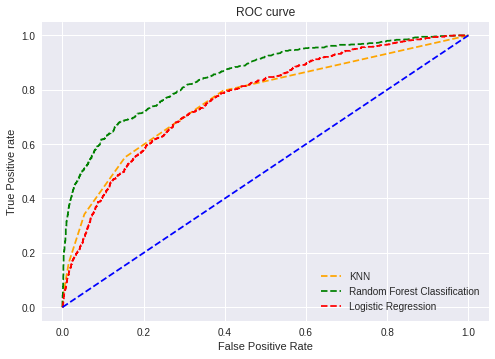

In [54]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_knn, tpr_knn, linestyle='--',color='orange', label='KNN')
plt.plot(fpr_rfc, tpr_rfc, linestyle='--',color='green', label='Random Forest Classification')
plt.plot(fpr_logreg, tpr_logreg, linestyle='--',color='red', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();